# Table des matières :
### * [Préparation des données](#first-bullet)
### * [Vérification et entrainement](#second-bullet)
### * [Préprocessing manuel](#third-bullet)
### * [Affichage resultats](#fourth-bullet)

## Préparation des données <a class="anchor" id="first-bullet"></a>


In [56]:
from fastai.vision.all import *
import fastai
import numpy as np
import os
import torchvision
from torchvision import transforms
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [57]:
torch.cuda.is_available()
torch.device('cpu')

device(type='cpu')

In [59]:
source = f'/home/remi/Documents/dataset_folder/DATASET'
#source = r'C:\Users\Remi\Pictures\DATASET-20210121T074943Z-001\DATASET'

df_marks = pd.DataFrame({'fname':['p0'], 'label':['oeuf'], 'is_valid':[True]})

#os.chdir(source)
for root, dirs, files in os.walk(source, topdown = False):
   for name in files:
      my_path = os.path.join(source, root, name)
      categorie = root.split("/")[7]
      #print(my_path)
      is_valid = False
      #if r'\003\frigo' in root:
      #if r'\003' in root:

      #  is_valid = True
      new_row = {'fname':my_path[9+14:], 'label':categorie, 'is_valid':is_valid}
      df_marks = df_marks.append(new_row, ignore_index=True)
df_marks = df_marks[2:]

#print(df_marks)

In [60]:
top_10_list = [str(x) for x in df_marks.groupby('label').agg([ 'count']).reset_index().sort_values([('fname', 'count')], ascending=False)['label'][0:10]]
df_marks.groupby('label').agg([ 'count']).reset_index().sort_values([('fname', 'count')], ascending=False)

,label,fname,is_valid
,,count,count
5,beurre,114,114
33,oeufs,106,106
15,crème fraiche,50,50
24,fromage rapé,44,44
29,lait,36,36
50,yaourt,31,31
32,mayonnaise,31,31
38,pateFeuilletee,28,28
48,thon,26,26


In [61]:
from torchvision import models

In [62]:
obj2cat = {
    "thon":"conserve",
    
    "mayonnaise":"pot",
    "yaourt":"pot",
    "moutarde":"pot",
    
    "pateFeuilletee":"pate",
    "PateBrisee":"pate",
    
    "crème fraiche":"creme_ou_lait",
    "lait de vache":"creme_ou_lait",
    
    
    "oeufs":"oeuf",
    
    "chocolat noir":"cube_et_rectangle",
    
    "beurre":"beurre",
    "poulet":"cube_et_rectangle",
    "saussice":"cube_et_rectangle",
    
    "Fromage rapé":"fromage",
    "fromage comté":"fromage",
    
    "salade":"legume",
    "oranges":"legume",
    "peche":"legume",
    "poireau":"legume"    
}

In [63]:
files = get_image_files(source)
files = [f for f in files]

In [64]:
set_list = []
for f in files:
    for top in obj2cat.keys():
        #print(f,top)
        if top in str(f):
            set_list.append(f)

In [65]:
def label_func(f): 
    #print(f)
    categorie = str(f).split("/")[7]#.replace(" ","_")
    return obj2cat[categorie]

In [102]:
idx_val = ["/000/fri" in str(x) for x in set_list]

def RandomSplitterRemi(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        rand_idx = L(int(i) for i in range(len(set_list)))
        return  rand_idx[[i==False for i in idx_val]], rand_idx[idx_val]
    return _inner

# Vérification et entrainement <a class="anchor" id="second-bullet"></a>

In [103]:
def ownCenterCrop(a):
    C,H,W = a.shape

    if H == W:
        pass
    elif H > W:
        dp = int((H-W)/2)
        a = a[:,dp:W+dp,:]
    else:
        dp = int((W-H)/2)
        a = a[:,:,dp:H+dp]  
    return(a)

In [104]:
class CenterResizeTransform(Transform):
    def __init__(self,size): self.size = size
        
    def encodes(self, img: PILImage):
        a = array(img)
        a = torch.tensor(a.astype(float)).permute(2,0,1)
        a = ownCenterCrop(a)
        a = torchvision.transforms.Resize((self.size,self.size))(a)
        return PILImage.create(a.permute(1,2,0).numpy().astype(np.uint8))

In [105]:
auf = aug_transforms(#size=128*3,
                                             mult=1.0, 
                                             do_flip=True, 
                                             flip_vert=False, 
                                             max_rotate=10.0, 
                                             min_zoom=1.0, 
                                             max_zoom=1.1, 
                                             max_lighting=0.2, #0.2
                                             max_warp=0.2, 
                                             p_affine=0.75, 
                                             p_lighting=1.0, #0.75
                                             xtra_tfms=None,
                                             mode='bilinear', 
                                             pad_mode='reflection', 
                                             align_corners=True, 
                                             batch=False, 
                                             min_scale=1.0
                                            
                  )

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_y     = label_func,
                   splitter  = RandomSplitterRemi(),
                   item_tfms = CenterResizeTransform(128*4),#Resize(128*4), WrapperTransform(),#
                   batch_tfms= auf)#,do_flip=False))

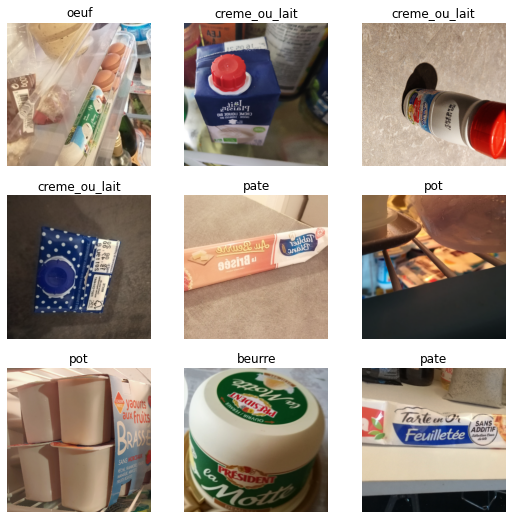

In [106]:
dls = dblock.dataloaders(set_list, bs=16)
dls.show_batch()

In [107]:
len(dls.train), len(dls.valid)

(27, 5)

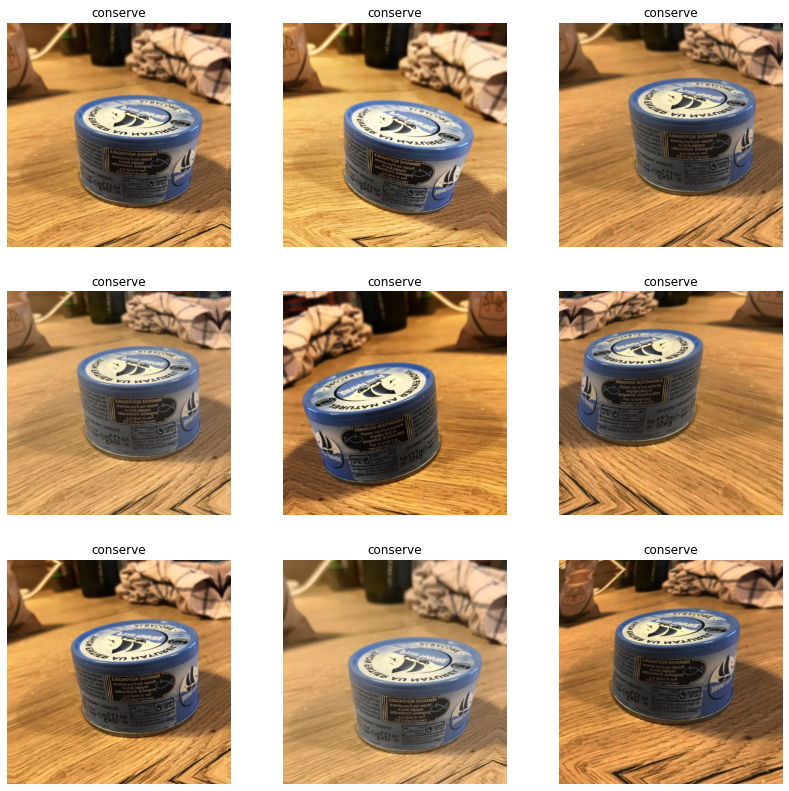

In [108]:
dls.show_batch(unique=True,figsize=(14,14))

In [109]:
def top_2_accuracy(inp, targ, k=5, axis=-1):
    return top_k_accuracy(inp, targ, k=2, axis=-1)

In [110]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy,error_rate,top_2_accuracy], cbs=SaveModelCallback())

In [ ]:
#learn.model

train=True
if false:
    learn.lr_find()

In [112]:
if train:
    import cProfile
    Pr=cProfile.Profile()
    Pr.enable()

    learn.fine_tune(15,   base_lr=0.01)

    Pr.disable()
    Pr.print_stats('time')

epoch,train_loss,valid_loss,accuracy,error_rate,top_2_accuracy,time
0,0.832698,3.335840,0.438356,0.561644,0.602740,00:29


Better model found at epoch 0 with valid_loss value: 3.3358404636383057.


epoch,train_loss,valid_loss,accuracy,error_rate,top_2_accuracy,time
0,0.467955,4.320382,0.506849,0.493151,0.575342,00:30
1,0.389379,4.955341,0.328767,0.671233,0.561644,00:30
2,0.402133,2.967155,0.438356,0.561644,0.602740,00:30
3,0.576561,7.075559,0.123288,0.876712,0.369863,00:29
4,0.652335,5.247134,0.369863,0.630137,0.561644,00:30
5,0.665565,4.359729,0.287671,0.712329,0.452055,00:29
6,0.512767,3.281710,0.383562,0.616438,0.575342,00:30
7,0.425824,3.901045,0.315068,0.684932,0.465753,00:30
8,0.375784,3.869351,0.410959,0.589041,0.684932,00:31
9,0.277735,3.429857,0.438356,0.561644,0.547945,00:30


Better model found at epoch 0 with valid_loss value: 4.320382118225098.
Better model found at epoch 2 with valid_loss value: 2.9671554565429688.
Better model found at epoch 10 with valid_loss value: 2.9054689407348633.
Better model found at epoch 12 with valid_loss value: 2.6771223545074463.
         13699970 function calls (13066427 primitive calls) in 486.422 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1028  395.318    0.385  395.326    0.385 {method 'poll' of 'select.poll' objects}
 1504/752   36.774    0.024   36.827    0.049 {method 'cpu' of 'torch._C._TensorBase' objects}
      432    4.228    0.010    4.228    0.010 {method 'run_backward' of 'torch._C._EngineBase' objects}
      256    4.159    0.016    4.166    0.016 {built-in method posix.fork}
2444/1420    2.611    0.001    2.697    0.002 {method 'to' of 'torch._C._TensorBase' objects}
20480/10240    2.095    0.000    2.509    0.000 {built-in method conv2

   160/80    0.001    0.000    0.002    0.000 {method 'expand_as' of 'torch._C._TensorBase' objects}
      548    0.001    0.000    0.001    0.000 display.py:720(_repr_html_)
      544    0.001    0.000    0.001    0.000 core.py:144(__getitem__)
     1492    0.001    0.000    0.001    0.000 threading.py:255(_release_save)
     1024    0.001    0.000    0.001    0.000 utils.py:29(_list_with_default)
      548    0.001    0.000    0.001    0.000 {method 'getvalue' of '_io.StringIO' objects}
      548    0.001    0.000    0.001    0.000 {method 'splitlines' of 'str' objects}
      548    0.001    0.000    0.087    0.000 <decorator-gen-3>:1(__call__)
      548    0.001    0.000    0.001    0.000 display.py:691(_check_data)
      256    0.001    0.000    0.929    0.004 process.py:142(join)
      256    0.001    0.000    0.003    0.000 queues.py:200(_finalize_close)
      264    0.001    0.000    0.040    0.000 serialization.py:173(default_restore_location)
        7    0.001    0.000    0.0

In [21]:
learn.dls.vocab

['beurre', 'conserve', 'creme_ou_lait', 'cube_et_rectangle', 'fromage', 'legume', 'oeuf', 'pate', 'pot']

# Préprocessing manuel <a class="anchor" id="third-bullet"></a>


In [113]:
from PIL import Image

source="inputs_data/beurreCarre.jpg"
im = Image.open(source)
type(im)

PIL.JpegImagePlugin.JpegImageFile

In [23]:
#learn.dls[0].__dict__

In [114]:
arr = np.asarray(im)
im3 = Image.fromarray(arr, 'RGB')
type(im3)

PIL.Image.Image

In [115]:
t = torch.tensor(arr).permute(2,0,1)
t1 = torchvision.transforms.Resize(128*4)(t)
tt = t1
t3 = t1/255.0
#t = torchvision.transforms.Resize(128*3)(t)
#t = torchvision.transforms.Resize(128*3)(t)
t3.shape

torch.Size([3, 512, 512])

In [116]:
regular_tf = transforms.Compose([ transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                                     std = [ 0.229, 0.224,0.225 ])])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),])

t4 = regular_tf(t3) 

# importing models

In [117]:
learn.load("model")

/home/remi/anaconda3/envs/fastaiv2/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [118]:
m = learn.model.cpu().eval()

In [119]:
example_inputs = torch.rand(1, 3, 224, 224)
resnet18_traced = torch.jit.trace(m, example_inputs = example_inputs)
resnet18_traced.save("resnet18_traced_fai.pt")

# Affichage resultats <a class="anchor" id="fourth-bullet"></a>

In [120]:
#learn.get_preds()[0].shape

dl = learn.dls.test_dl([source], rm_type_tfms=None, num_workers=0)
#dl.after_batch.fs[2]=Brightness(max_lighting=0.0, p=1, draw=None, batch=False)

inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
inp.sum(), preds

(TensorImage(500670.2188),
 tensor([[9.7136e-01, 2.4533e-05, 4.4906e-03, 7.4840e-03, 1.0933e-02, 3.3378e-04,
          2.4266e-03, 2.6719e-03, 2.7458e-04]]))

In [121]:
r = ToTensor()(Resize(128*4)(dl.__stored_args__["dataset"][0][0]))

In [122]:
r2 = Transform()((Resize(128*4)(dl.__stored_args__["dataset"][0][0])))

In [123]:
x = dl.__stored_args__["dataset"][0][0]
type(x)

fastai.vision.core.PILImage

In [124]:
r1 = Resize(128*4)(x)
r2 = array(r1)

In [125]:
r3 = torch.tensor(r2)

In [126]:
r3 = r3.float()

In [127]:
r3.shape

torch.Size([512, 512, 3])

In [128]:
#r4 = Resize(128*4)(r3)

In [129]:
r4 = regular_tf(r3.permute(2,0,1)/255) 

In [130]:
r4.shape

torch.Size([3, 512, 512])

In [131]:
(r4 - inp.squeeze(0)).min()

TensorImage(-0.5252)

In [132]:
#learn.cpu()
#torch.nn.Softmax(dim=1)(learn.model(t.unsqueeze(0)))

In [133]:
#original
learn.predict("/home/remi/Documents/testimg/beurreCarre.jpg")

('beurre',
 tensor(0),
 tensor([9.7136e-01, 2.4533e-05, 4.4906e-03, 7.4840e-03, 1.0933e-02, 3.3378e-04,
         2.4266e-03, 2.6719e-03, 2.7458e-04]))